<h1><center>High Traffic Clustering</center></h1>

Bu notebook, high ve non-high trafik noktalarının belirlenmesi için **Türkiye genelinde** Traditional channel'da 2'li hierarchical clustering çalışmasıdır.

In [1]:
# Database Connection
from google.cloud import bigquery, bigquery_storage_v1beta1

# Basic
import os
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import datetime as dt

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Model
import pickle
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.svm import SVC
from scipy.special import boxcox1p
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, Birch, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")
# sns.color_palette('bright')
sns.set_palette('dark')

In [2]:
xls = pd.ExcelFile('traffic_high_low.xlsx')
df_high = pd.read_excel(xls, 'High Traffic')
df_non = pd.read_excel(xls, 'Non-high Traffic')
all_data = pd.read_excel(xls, 'all_data')

In [3]:
all_data.head()

,outlet_number,outlet_name,high_traffic
0,9422535,Şampiyon Tekel & Gıda,0
1,9109019,Flamingo Tekel,0
2,9489908,Fıçı Tekel,0
3,3008089,Yerlisu Gıda,0
4,9566010,Kupa Tekel,0


In [4]:
shopper_df = pd.read_csv('shopper_data.csv')

In [5]:
shopper_df = shopper_df.fillna(0)

In [6]:
len(shopper_df)

304608

In [7]:
shopper_df.head()

,outlet_number,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,HANE_BUYUKLUGU,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,7173090,DAVUT BIRLES,POINT(29.06531874 40.1851168),22528,ON-PREMISE,C1,SIFIR,Bursa,Osmangazi,0.663415,...,0.0,0.000,0.000,0.0,4.225,0.000,0.0,0.0,0.000,0.00
1,7158909,DOGAN TEKEL,POINT(29.06616217 40.18558327),22528,TRADITIONAL RETAIL,C1,SIFIR,Bursa,Osmangazi,0.663415,...,0.0,0.000,0.000,0.0,70.906,33.571,0.0,0.0,8.452,0.00
2,9082733,KARDESLER PIDE,POINT(29.06576674 40.18505304),22528,ON-PREMISE,C1,SIFIR,Bursa,Osmangazi,0.663415,...,0.0,49.855,1605.880,0.0,134.430,8.364,0.0,0.0,0.000,42.52
3,9468815,IHLAMURALTI CAY BAHCESI,POINT(29.0648084200769 40.1860698786783),22528,ON-PREMISE,C1,SIFIR,Bursa,Osmangazi,0.663415,...,0.0,0.000,46.486,0.0,5.070,0.000,0.0,0.0,0.000,0.00
4,8921197,PARALI BUFE,POINT(29.0647642900001 40.18573423),22528,ON-PREMISE,C1,SIFIR,Bursa,Osmangazi,0.663415,...,0.0,0.000,88.746,0.0,37.403,2.091,0.0,0.0,0.000,2.79


In [8]:
shopper_df.ILADI.value_counts()

İstanbul     52534
İzmir        20397
Ankara       18468
Antalya      13285
Bursa         9460
             ...  
Çankırı        532
Kilis          510
Ardahan        415
Bayburt        201
Gümüşhane      184
Name: ILADI, Length: 81, dtype: int64

In [9]:
#Sadece İstanbul, Ankara, İzmir genelini aldım.
#df_new = shopper_df.query(""" ILADI == 'İstanbul' or ILADI == 'İzmir' or ILADI == 'Ankara' """).reset_index(drop=True)

df_new = shopper_df.query(""" ILADI == 'Hatay' """).reset_index(drop=True)

In [10]:
len(df_new)

5141

In [11]:
df_new.head(3)

,outlet_number,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,HANE_BUYUKLUGU,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,9536760,HIDIR BAKKALIYESI,POINT(36.1690703127533 36.2035302445292),32519,TRADITIONAL RETAIL,D,MIDDLE AGED,Hatay,Antakya,1.472834,...,0.0,0.0,0.000,0.0,50.720,4.879,0.0,0.0,0.0,0.000
1,9328270,CEYLAN BAKKALI,POINT(36.17142515 36.2055033299999),32519,TRADITIONAL RETAIL,D,MIDDLE AGED,Hatay,Antakya,1.472834,...,0.0,0.0,0.000,0.0,36.562,4.331,0.0,0.0,0.0,0.000
2,8989164,LEVENT OGUTMEN(OGUTMEN BAKKALI),POINT(36.1700709399999 36.2042689900001),32519,TRADITIONAL RETAIL,D,MIDDLE AGED,Hatay,Antakya,1.472834,...,0.0,0.0,2.113,0.0,25.250,1.120,0.0,0.0,0.0,9.297


In [12]:
df_new.MAIN_CHANNEL.unique()

array(['TRADITIONAL RETAIL', 'ON-PREMISE', 'MODERN RETAIL',
       'OTHER/THIRD PARTY'], dtype=object)

In [13]:
# data = Class'ları belli olan dataframe
class_data = pd.merge(all_data[["outlet_number","high_traffic"]], df_new, on='outlet_number', how='left')

In [14]:
# Sadece bu Hatayı içeren toplam 0 satır var. 
#iller_data = class_data.query(""" ILADI == 'İstanbul' or ILADI == 'İzmir' or ILADI == 'Ankara' """).reset_index(drop=True)

iller_data = class_data.query(""" ILADI == 'Hatay' """).reset_index(drop=True)

In [15]:
iller_data.head(2)

,outlet_number,high_traffic,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE


### Data Prep.

In [16]:
prep_data = df_new.copy()

In [17]:
prep_data.MAIN_CHANNEL.unique()

array(['TRADITIONAL RETAIL', 'ON-PREMISE', 'MODERN RETAIL',
       'OTHER/THIRD PARTY'], dtype=object)

In [18]:
# sadece traditional olanları al.
prep_data = prep_data.query("MAIN_CHANNEL=='TRADITIONAL RETAIL'").reset_index(drop=True)

In [19]:
model_data = prep_data.copy()

In [20]:
len(model_data)

3232

#### Label Encoding

In [21]:
model_data["SES"] = model_data["SES"].replace({'A': 6, 'B': 5, 'C1': 4, 'C2': 3, 'D': 2, 'E': 1})

#### Gece Gündüz Oranı

In [22]:
# drop columns for final data for model
model_data = model_data.drop(["outlet_name"                   
                             ,"GEOGPOINT"
                             ,"IDARIID"
                             ,"MAIN_CHANNEL"
                             ,"YAS_CLUSTER"
                             ,"ILADI"
                             ,"ILCEADI"
                             ,"HANE_BUYUKLUGU"
                             ,"ZENGINLIK_INDEKSI"
                             ,"BURN"
                             ,"CAPPY"
                             ,"CC_LIGHT"
                             ,"CC_NO_SUGER"
                             ,"COCACOLA"
                             ,"COCACOLA_ENERGY"
                             ,"DAMLA_MINERA"
                             ,"DAMLA_WATER"
                             ,"EXOTIC"
                             ,"FANTA"
                             ,"FUSETEA"
                             ,"MONSTER"
                             ,"POWERADE"
                             ,"SCHWEPPES"
                             ,"SPRITE"
                             ],axis=1)

In [23]:
model_data['GECE_NUFUS'].replace({0: 0.00001}, inplace=True)
model_data['GUNDUZ_NUFUS'].replace({0: 0.00001}, inplace=True)

In [24]:
model_data.head(3)

,outlet_number,SES,GUNDUZ_NUFUS,GECE_NUFUS,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,...,DEMIRYOLU,DENIZYOLU,HAVAYOLU,KARAYOLU,TRAFIK,E_COMMERCE,MODERN_RETAIL,ON_PREMISE,OTHER_THIRD_PARTY,TRADITIONAL_RETAIL
0,9536760,2,0.00001,1003,5.966139,6.987843,2214,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9328270,2,0.00001,1003,5.966139,6.987843,2214,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,8989164,2,0.00001,1003,5.966139,6.987843,2214,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [25]:
g = model_data[['GUNDUZ_NUFUS','GECE_NUFUS']]

In [26]:
model_data["gündüz_gece_oran"] = g["GUNDUZ_NUFUS"]/g["GECE_NUFUS"]

In [27]:
model_data.head(3)

,outlet_number,SES,GUNDUZ_NUFUS,GECE_NUFUS,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,...,DENIZYOLU,HAVAYOLU,KARAYOLU,TRAFIK,E_COMMERCE,MODERN_RETAIL,ON_PREMISE,OTHER_THIRD_PARTY,TRADITIONAL_RETAIL,gündüz_gece_oran
0,9536760,2,0.00001,1003,5.966139,6.987843,2214,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.970090e-09
1,9328270,2,0.00001,1003,5.966139,6.987843,2214,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.970090e-09
2,8989164,2,0.00001,1003,5.966139,6.987843,2214,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,9.970090e-09


In [28]:
model_data = model_data.fillna(0)

In [29]:
model_data = model_data.drop(["outlet_number"                   
                             ,'GUNDUZ_NUFUS'
                             ,'GECE_NUFUS'],axis=1)

In [30]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SES                              3232 non-null   int64  
 1   SEHIRLESME_INDEKSI               3232 non-null   float64
 2   YAYA_TRAFIGI                     3232 non-null   float64
 3   AYLIK_HARCAMA                    3232 non-null   int64  
 4   GIDAVEICECEK                     3232 non-null   float64
 5   ALKOLTUTUN                       3232 non-null   float64
 6   EGLENCEKULTUR                    3232 non-null   float64
 7   LOKANTAOTEL                      3232 non-null   float64
 8   GIDAVEICECEK_ORAN                3232 non-null   float64
 9   ALKOLTUTUN_ORAN                  3232 non-null   float64
 10  EGLENCEKULTUR_ORAN               3232 non-null   float64
 11  LOKANTAOTEL_ORAN                 3232 non-null   float64
 12  ISYERI_YOGUNLUGU_SAY

#### Scaling and Normal Dist.

In [31]:
# define a method to scale data, looping thru the columns, and passing a scaler
def scale_data(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    for col in data.columns:
        data[col] = min_max_scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

In [32]:
def normal_dist(data):
    for col in data.columns:
        data[col] = data[col].apply(lambda x: boxcox1p(x,0.25))
        stats.boxcox(data[col])[0]
    return data

In [33]:
def log_data(data):
    for col in data.columns:
        data[col] = data[col].apply(lambda x: np.log(x))
    return data

In [34]:
copy_data = model_data.copy()

In [35]:
copy_data.head(2)

,SES,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,LOKANTAOTEL,GIDAVEICECEK_ORAN,ALKOLTUTUN_ORAN,...,DENIZYOLU,HAVAYOLU,KARAYOLU,TRAFIK,E_COMMERCE,MODERN_RETAIL,ON_PREMISE,OTHER_THIRD_PARTY,TRADITIONAL_RETAIL,gündüz_gece_oran
0,2,5.966139,6.987843,2214,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.970090e-09
1,2,5.966139,6.987843,2214,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.970090e-09


In [36]:
copy_data = copy_data.drop(["IL_BAZLI_TURIST_YERLI_ISLETME","IL_BAZLI_TURIST_YBN_ISLETME"],axis=1)

In [37]:
copy_data[copy_data < 0] = 0

In [38]:
copy_data.replace({0: 0.00001}, inplace=True)

#### Normal Dist. Part 

Comment satırı içinde olan sütunlar, sabit(aynı) değerler içerdiğinden normalize edilemeyen değerlerdir. (ilerde buna göre bir fonksiyon yazabilirsin)

In [40]:
copy_data["SES"] = stats.boxcox(copy_data["SES"])[0]
copy_data["SEHIRLESME_INDEKSI"] = stats.boxcox(copy_data["SEHIRLESME_INDEKSI"])[0]
copy_data["YAYA_TRAFIGI"] = stats.boxcox(copy_data["YAYA_TRAFIGI"])[0]
copy_data["AYLIK_HARCAMA"] = stats.boxcox(copy_data["AYLIK_HARCAMA"])[0]
copy_data["GIDAVEICECEK"] = stats.boxcox(copy_data["GIDAVEICECEK"])[0]
copy_data["ALKOLTUTUN"] = stats.boxcox(copy_data["ALKOLTUTUN"])[0]
copy_data["EGLENCEKULTUR"] = stats.boxcox(copy_data["EGLENCEKULTUR"])[0]
copy_data["LOKANTAOTEL"] = stats.boxcox(copy_data["LOKANTAOTEL"])[0]
copy_data["GIDAVEICECEK_ORAN"] = stats.boxcox(copy_data["GIDAVEICECEK_ORAN"])[0]
copy_data["ALKOLTUTUN_ORAN"] = stats.boxcox(copy_data["ALKOLTUTUN_ORAN"])[0]
copy_data["EGLENCEKULTUR_ORAN"] = stats.boxcox(copy_data["EGLENCEKULTUR_ORAN"])[0]
copy_data["LOKANTAOTEL_ORAN"] = stats.boxcox(copy_data["LOKANTAOTEL_ORAN"])[0]
copy_data["ISYERI_YOGUNLUGU_SAYI_KM2_YERLE"] = stats.boxcox(copy_data["ISYERI_YOGUNLUGU_SAYI_KM2_YERLE"])[0]
copy_data["ISYERI_YOGUNLUGU_SAYI_KM2"] = stats.boxcox(copy_data["ISYERI_YOGUNLUGU_SAYI_KM2"])[0]
copy_data["KONUT_YOGUNLUGU_SAYI_KM2_YERLES"] = stats.boxcox(copy_data["KONUT_YOGUNLUGU_SAYI_KM2_YERLES"])[0]
copy_data["KONUT_YOGUNLUGU_SAYI_KM2"] = stats.boxcox(copy_data["KONUT_YOGUNLUGU_SAYI_KM2"])[0]
#copy_data["IL_BAZLI_TURIST_YERLI_ISLETME"] = stats.boxcox(copy_data["IL_BAZLI_TURIST_YERLI_ISLETME"])[0]
#copy_data["IL_BAZLI_TURIST_YBN_ISLETME"] = stats.boxcox(copy_data["IL_BAZLI_TURIST_YBN_ISLETME"])[0]
copy_data["ORTA_ALT"] = stats.boxcox(copy_data["ORTA_ALT"])[0]
copy_data["ORTA"] = stats.boxcox(copy_data["ORTA"])[0]
copy_data["ORTA_UST"] = stats.boxcox(copy_data["ORTA_UST"])[0]
copy_data["UST"] = stats.boxcox(copy_data["UST"])[0]
copy_data["AKARYAKIT"] = stats.boxcox(copy_data["AKARYAKIT"])[0]
copy_data["ALISVERIS"] = stats.boxcox(copy_data["ALISVERIS"])[0]
copy_data["OUTLET"] = stats.boxcox(copy_data["OUTLET"])[0]
copy_data["KONUT"] = stats.boxcox(copy_data["KONUT"])[0]
copy_data["EGITIM"] = stats.boxcox(copy_data["EGITIM"])[0]
copy_data["UNIVERSITE"] = stats.boxcox(copy_data["UNIVERSITE"])[0]
copy_data["EGLENCE"] = stats.boxcox(copy_data["EGLENCE"])[0]
copy_data["KULTUREL"] = stats.boxcox(copy_data["KULTUREL"])[0]
copy_data["TURIZM"] = stats.boxcox(copy_data["TURIZM"])[0]
copy_data["SPOR"] = stats.boxcox(copy_data["SPOR"])[0]
copy_data["HASTANE"] = stats.boxcox(copy_data["HASTANE"])[0]
copy_data["ASKERI"] = stats.boxcox(copy_data["ASKERI"])[0]
copy_data["DEMIRYOLU"] = stats.boxcox(copy_data["DEMIRYOLU"])[0]
#copy_data["DENIZYOLU"] = stats.boxcox(copy_data["DENIZYOLU"])[0]
#copy_data["HAVAYOLU"] = stats.boxcox(copy_data["HAVAYOLU"])[0]
copy_data["KARAYOLU"] = stats.boxcox(copy_data["KARAYOLU"])[0]
copy_data["TRAFIK"] = stats.boxcox(copy_data["TRAFIK"])[0]
#copy_data["E_COMMERCE"] = stats.boxcox(copy_data["E_COMMERCE"])[0]
copy_data["MODERN_RETAIL"] = stats.boxcox(copy_data["MODERN_RETAIL"])[0]
copy_data["ON_PREMISE"] = stats.boxcox(copy_data["ON_PREMISE"])[0]
copy_data["OTHER_THIRD_PARTY"] = stats.boxcox(copy_data["OTHER_THIRD_PARTY"])[0]
copy_data["TRADITIONAL_RETAIL"] = stats.boxcox(copy_data["TRADITIONAL_RETAIL"])[0]

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


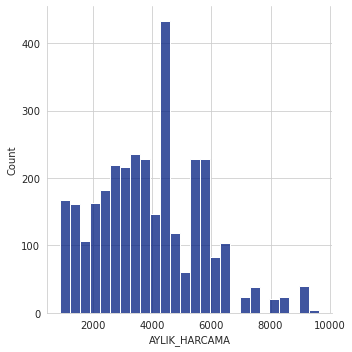

In [41]:
sns.displot(model_data['AYLIK_HARCAMA'])

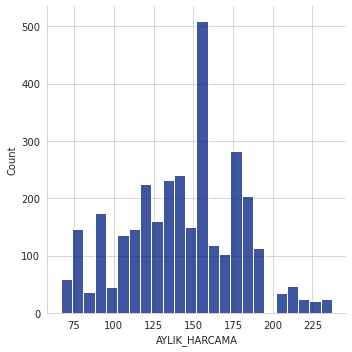

In [42]:
sns.displot(copy_data["AYLIK_HARCAMA"])

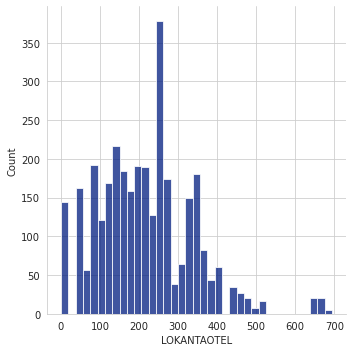

In [43]:
sns.displot(model_data["LOKANTAOTEL"])

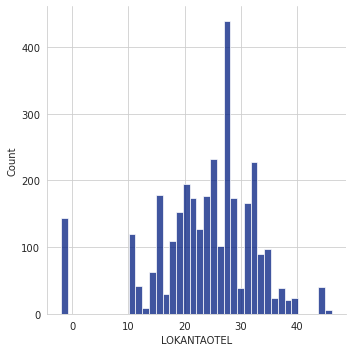

In [44]:
sns.displot(copy_data["LOKANTAOTEL"])

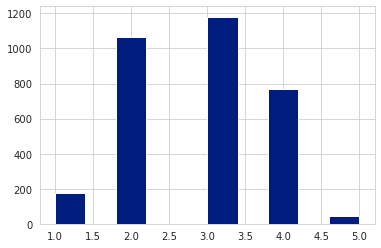

In [45]:
model_data.SES.hist()

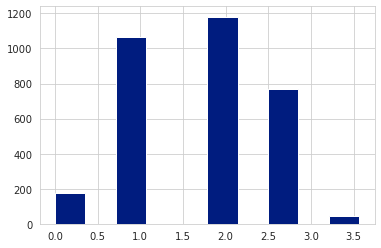

In [46]:
copy_data.SES.hist()

#### Scaling Part

In [47]:
scale_df = copy_data.copy()

In [48]:
scale_df = scale_data(scale_df)

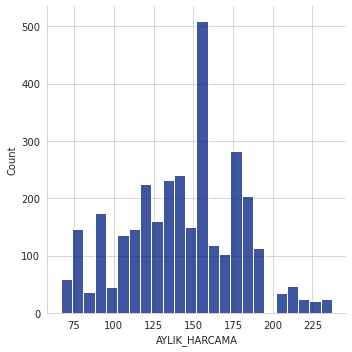

In [49]:
sns.displot(copy_data['AYLIK_HARCAMA'])

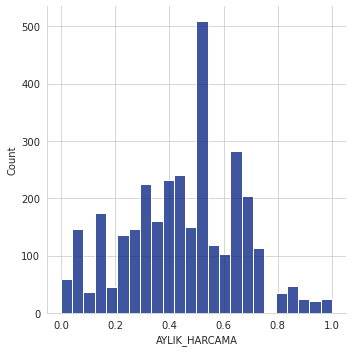

In [50]:
sns.displot(scale_df["AYLIK_HARCAMA"])

# Model 

In [51]:
scale_df.isna().all().all()

False

### Read Model

In [52]:
# load the model
hrc_model = pickle.load(open("model.pkl", "rb"))

In [ ]:
'''with open('hrc_model.pickle', 'rb') as f:
    hrc_model = pickle.load(f)'''

In [53]:
hrc_preds = hrc_model.fit_predict(scale_df)

In [54]:
final_df = prep_data.copy()

In [55]:
final_df["hrc_preds"] = hrc_preds

In [56]:
final_df["hrc_preds"].unique()

array([0, 1])

In [57]:
final_df['hrc_preds'].value_counts()

1    2059
0    1173
Name: hrc_preds, dtype: int64

In [58]:
final_df.head()

,outlet_number,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,HANE_BUYUKLUGU,...,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE,hrc_preds
0,9536760,HIDIR BAKKALIYESI,POINT(36.1690703127533 36.2035302445292),32519,TRADITIONAL RETAIL,D,MIDDLE AGED,Hatay,Antakya,1.472834,...,0.000,0.000,0.0,50.720,4.879,0.0,0.0,0.0,0.000,0
1,9328270,CEYLAN BAKKALI,POINT(36.17142515 36.2055033299999),32519,TRADITIONAL RETAIL,D,MIDDLE AGED,Hatay,Antakya,1.472834,...,0.000,0.000,0.0,36.562,4.331,0.0,0.0,0.0,0.000,0
2,8989164,LEVENT OGUTMEN(OGUTMEN BAKKALI),POINT(36.1700709399999 36.2042689900001),32519,TRADITIONAL RETAIL,D,MIDDLE AGED,Hatay,Antakya,1.472834,...,0.000,2.113,0.0,25.250,1.120,0.0,0.0,0.0,9.297,0
3,9197594,GENCOGLU BAKKALI,POINT(36.17202223 36.20484399),32519,TRADITIONAL RETAIL,D,MIDDLE AGED,Hatay,Antakya,1.472834,...,0.000,0.000,0.0,38.822,7.393,0.0,0.0,0.0,0.000,0
4,9363757,GUL TICARET,POINT(36.1705809831619 36.2063772836701),32519,TRADITIONAL RETAIL,D,MIDDLE AGED,Hatay,Antakya,1.472834,...,17.745,395.131,0.0,1307.493,414.928,0.0,0.0,0.0,218.387,0


In [59]:
comparison_df2 = pd.merge(iller_data, final_df, on='outlet_number')

In [60]:
conf_df2 = comparison_df2[["high_traffic","hrc_preds"]]
conf_df2

,high_traffic,hrc_preds


In [61]:
TP_ = len(conf_df2.query("high_traffic == 1 & hrc_preds == 1")) 
FP_ = len(conf_df2.query("high_traffic == 1 & hrc_preds == 0"))
FN_ = len(conf_df2.query("high_traffic == 0 & hrc_preds == 1"))
TN_ = len(conf_df2.query("high_traffic == 0 & hrc_preds == 0"))

In [62]:
print("TP is:", TP_)
print("FP is:", FP_)
print("FN is:", FN_)
print("TN is:", TN_)

TP is: 0
FP is: 0
FN is: 0
TN is: 0


In [ ]:
print("Accuracy is: %", (TP_+TN_)/(TP_+TN_+FN_+FP_)*100)

In [63]:
# extract coordinates
final_df["x"] = final_df["GEOGPOINT"].apply(lambda x: x.split(")")[0].split("POINT(")[1].split(" ")[1])
final_df["y"] = final_df["GEOGPOINT"].apply(lambda x: x.split(")")[0].split("POINT(")[1].split(" ")[0])

In [64]:
final_df["y"] = pd.to_numeric(final_df["y"], downcast="float")
final_df["x"] = pd.to_numeric(final_df["x"], downcast="float")

## Decision Points

In [65]:
# decision tree için kullanılacak bu data; içinde scale edilmiş değerler yanında hier. clustering prediction'larını da içerir.
decision_df = scale_df.copy()

In [66]:
decision_df['hrc_preds'] = hrc_preds

In [67]:
from sklearn.model_selection import train_test_split

x = decision_df.drop('hrc_preds', axis=1)
y = decision_df['hrc_preds']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)
    
dc = DecisionTreeClassifier(criterion="entropy", random_state=42) 
dc.fit(x_train, y_train)
dc_pred = dc.predict(x_test)

d_text = tree.export_text(dc)
print(d_text)

|--- feature_17 <= 0.49
|   |--- feature_28 <= 0.50
|   |   |--- feature_29 <= 0.50
|   |   |   |--- feature_36 <= 0.49
|   |   |   |   |--- feature_9 <= 0.30
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_9 >  0.30
|   |   |   |   |   |--- feature_21 <= 0.89
|   |   |   |   |   |   |--- feature_13 <= 0.85
|   |   |   |   |   |   |   |--- feature_30 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_21 <= 0.41
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_21 >  0.41
|   |   |   |   |   |   |   |   |   |--- feature_38 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_27 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- feature_27 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- feature_38 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_3 <= 0.64
|   |   |   |   

In [68]:
from sklearn import metrics
metrics.accuracy_score(y_test, dc_pred)

0.9578256794751641

In [69]:
dc.feature_importances_

array([0.00136094, 0.02198615, 0.01149806, 0.00782167, 0.        ,
       0.00795547, 0.00136094, 0.00340697, 0.00136094, 0.06551794,
       0.        , 0.0038663 , 0.01173099, 0.01860139, 0.00813036,
       0.00758874, 0.        , 0.31201815, 0.        , 0.        ,
       0.00720216, 0.05286362, 0.0202768 , 0.00945317, 0.01083356,
       0.        , 0.        , 0.00970899, 0.1044633 , 0.10556656,
       0.00778768, 0.        , 0.        , 0.        , 0.        ,
       0.00446296, 0.08725197, 0.        , 0.00398973, 0.05402068,
       0.        , 0.02675486, 0.01115897])

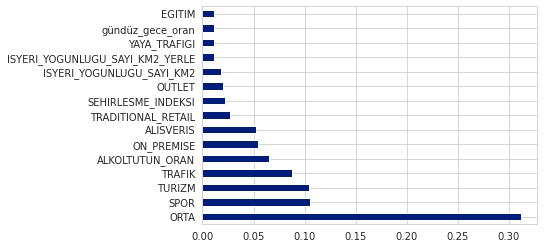

In [70]:
pd.Series(dc.feature_importances_, index=x_train.columns).nlargest(15).plot(kind='barh')

In [71]:
analysis_df = final_df.drop([ 
"MAIN_CHANNEL"                                             
,"YAS_CLUSTER"                    
,"ILADI"                          
,"ILCEADI"  
,"GEOGPOINT"
,"IDARIID"
,"HANE_BUYUKLUGU"
,"x","y"
],axis=1)

In [72]:
final_high = analysis_df.query("hrc_preds == 1")
final_low = analysis_df.query("hrc_preds == 0") 

In [73]:
final_high.describe()

,outlet_number,GUNDUZ_NUFUS,GECE_NUFUS,ZENGINLIK_INDEKSI,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,...,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE,hrc_preds
count,2.059000e+03,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,...,2059.000000,2059.000000,2059.0,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.0
mean,9.065971e+06,7752.996600,9653.596892,1.637253,6.203778,7.256570,3516.737737,844.172092,156.789733,89.117867,...,11.412707,63.754672,0.0,164.914224,39.367316,0.714613,1.538015,3.332317,48.894307,1.0
std,1.348341e+06,10359.478963,8655.623961,0.859909,2.809575,1.361763,1568.254950,322.995100,65.293818,46.920128,...,30.982583,176.150263,0.0,443.521537,123.383577,8.366658,8.985893,14.897576,299.166041,0.0
min,2.701600e+05,61.000000,119.000000,0.002223,1.000000,1.000000,1073.000000,306.090000,53.650000,16.095000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,9.125390e+06,1555.000000,3386.000000,1.072000,4.001464,6.993875,2440.000000,629.520000,114.680000,58.560000,...,0.000000,0.000000,0.0,48.281000,2.810000,0.000000,0.000000,0.000000,10.482000,1.0
50%,9.496550e+06,3931.000000,6817.000000,1.649000,6.995945,7.057194,3559.000000,854.160000,153.784000,85.944000,...,2.535000,6.339000,0.0,90.918000,14.874000,0.000000,0.000000,0.000000,25.995000,1.0
75%,9.617894e+06,9170.000000,12198.000000,2.182500,8.069751,7.999836,4547.000000,1087.800000,195.564000,113.700000,...,10.985000,42.260000,0.0,163.515500,40.302500,0.000000,1.057000,2.113000,48.426500,1.0
max,1.074090e+07,53650.000000,35371.000000,5.155000,9.999926,9.883840,9643.000000,1851.910000,373.780000,318.219000,...,583.050000,2449.704000,0.0,14855.548000,3763.203000,354.750000,343.525000,321.628000,13089.983000,1.0


In [74]:
final_low.describe()

,outlet_number,GUNDUZ_NUFUS,GECE_NUFUS,ZENGINLIK_INDEKSI,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,...,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE,hrc_preds
count,1.173000e+03,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,...,1173.000000,1173.000000,1173.0,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.0
mean,8.991439e+06,12485.376812,9364.934356,2.296388,8.081033,8.105920,4648.433930,939.867050,179.516462,110.326852,...,10.164790,80.514159,0.0,146.691479,43.698815,0.700146,1.552610,4.332951,41.216508,0.0
std,1.470574e+06,11348.696447,8615.085840,1.022432,1.739833,1.184655,1804.731796,471.281306,96.058919,69.823619,...,23.840378,212.077278,0.0,354.850017,88.110562,3.245067,4.005481,10.984382,89.083670,0.0
min,2.711640e+05,0.000000,162.000000,0.082498,1.000000,2.001173,903.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,-0.966000,-43.638000,0.000000,0.000000,0.000000,0.000000,0.0
25%,9.085528e+06,3560.000000,3455.000000,1.531000,6.999611,7.700971,3334.000000,678.384000,126.524000,65.928000,...,0.000000,0.000000,0.0,35.061000,4.182000,0.000000,0.000000,0.000000,8.771000,0.0
50%,9.446257e+06,8695.000000,7058.000000,2.133000,8.794371,7.998542,4454.000000,1038.960000,186.147000,108.225000,...,1.690000,10.565000,0.0,73.121000,18.170000,0.000000,0.000000,0.000000,23.734000,0.0
75%,9.608386e+06,19040.000000,11697.000000,2.922000,9.069918,8.999761,5774.000000,1278.450000,254.056000,160.048000,...,10.985000,61.279000,0.0,141.302000,47.334000,0.000000,1.057000,3.804000,44.526000,0.0
max,2.000507e+07,53650.000000,35371.000000,4.839000,9.999926,9.983254,9123.000000,1851.910000,373.780000,301.059000,...,494.325000,2983.578000,0.0,7179.575000,1234.110000,84.824000,63.420000,156.404000,1781.453000,0.0


#### High Traffic

In [ ]:
print("High Traffic çıkan toplam outlet sayısı : ", final_high.outlet_number.nunique(), "\n")

print("High Traffic'in ortalama aylık harcaması: ", final_high['AYLIK_HARCAMA'].mean(), "\n") 

print("High Traffic'in ortalama yaya trafiği: ", final_high['YAYA_TRAFIGI'].mean(), "\n") 

print("High Traffic'in A,B,C1 kategorisindeki toplam outlet sayısı oranı: ", "%",final_high.query("SES == 'A' or SES == 'B' or SES == 'C1'").outlet_number.nunique()/len(final_high.SES) * 100  , "\n")

print("High Traffic'in ortalama Gündüz Nufusu sayısı: ", final_high.GUNDUZ_NUFUS.mean(), "\n")

print("High Traffic'in ortalama Gece Nufusu sayısı: ", final_high.GECE_NUFUS.mean(), "\n")

print("High Traffic'in ortalama Eğitim birimi sayısı: ", final_high.EGITIM.mean())
print("High Traffic'in minimum Eğitim birimi sayısı: ", final_high.EGITIM.min())
print("High Traffic'in maximum Eğitim birimi sayısı: ", final_high.EGITIM.max(), "\n")

print("High Traffic'in ortalama Modern Retail birimi sayısı: ", final_high.MODERN_RETAIL.mean(), "\n")

print("High Traffic'in ortalama Spor birimi sayısı: ", final_high.SPOR.mean(), "\n")

<br>

#### Non-high Traffic

In [ ]:
print("Non-high Traffic çıkan toplam outlet sayısı : ", final_low.outlet_number.nunique(), "\n")

print("Non-high Traffic'in ortalama aylık harcaması: ", final_low['AYLIK_HARCAMA'].mean(), "\n") 

print("Non-high Traffic'in ortalama yaya trafiği: ", final_low['YAYA_TRAFIGI'].mean(), "\n") 

print("Non-high Traffic'in A,B,C1 kategorisindeki toplam outlet sayısı oranı: ", "%", final_low.query("SES == 'A' or SES == 'B' or SES == 'C1'").outlet_number.nunique()/len(final_low.SES) * 100  , "\n")

print("Non-high Traffic'in ortalama Gündüz Nufusu sayısı: ", final_low.GUNDUZ_NUFUS.mean(), "\n")

print("Non-high Traffic'in ortalama Gece Nufusu sayısı: ", final_low.GECE_NUFUS.mean(), "\n")

print("Non-high'in ortalama Eğitim birimi sayısı: ", final_low.EGITIM.mean())
print("Non-high'in minimum Eğitim birimi sayısı: ", final_low.EGITIM.min())
print("Non-high'in maximum Eğitim birimi sayısı: ", final_low.EGITIM.max(), "\n")

print("Non-high'in ortalama Modern Retail birimi sayısı: ", final_low.MODERN_RETAIL.mean(), "\n")

print("Non-high'in ortalama Spor birimi sayısı: ", final_low.SPOR.mean(), "\n")

### Graph

In [ ]:
column_names = ["BURN"
,"CAPPY"                            
,"CC_LIGHT"                         
,"CC_NO_SUGER"                      
,"COCACOLA"                         
,"COCACOLA_ENERGY"                  
,"DAMLA_MINERA"                     
,"DAMLA_WATER"                      
,"EXOTIC"                           
,"FANTA"                            
,"FUSETEA"                          
,"MONSTER"                          
,"POWERADE"                         
,"SCHWEPPES"]                      

In [ ]:
final_high_brands = final_high[column_names].reset_index(drop=True)

In [ ]:
high_brands_sum = pd.DataFrame(final_high_brands.sum()).reset_index()

In [ ]:
high_brands_sum.rename({"index": "brand", 0: "values",} ,axis=1,inplace=True)

In [ ]:
high_brands_sum

In [ ]:
fig = px.pie(high_brands_sum, values='values', names="brand", title='Brand Dist. in High Traffic Cluster')
fig.show()

In [ ]:
final_high.groupby('SES')['outlet_number'].sum().sort_values()

In [ ]:
non_high_brands = final_low[column_names].reset_index(drop=True)

In [ ]:
non_brands_sum = pd.DataFrame(non_high_brands.sum()).reset_index()

In [ ]:
non_brands_sum.rename({"index": "brand", 0: "values",} ,axis=1,inplace=True)

In [ ]:
non_brands_sum.query("brand == 'CC_LIGHT'")

In [ ]:
fig = px.pie(non_brands_sum, values='values', names="brand", title='Brand Dist. in Non-high Traffic Cluster')
fig.show()

In [ ]:
final_low.groupby('SES')['outlet_number'].sum().sort_values()

In [ ]:
stophere

#### Save as CSV

In [ ]:
csv_df = final_df.copy()

In [ ]:
csv_df = csv_df.rename({"hrc_preds": "high_traffic"}, axis=1)

In [ ]:
csv_df.head(2)

In [ ]:
csv_df.to_csv("hatay_high_traffic.csv")

----

In [75]:
# bigquery'e tabloyu ekleme
# Database Connection
from google.cloud import bigquery, bigquery_storage_v1beta1

client = bigquery.Client()

table_id = "coca-cola-data-lake.predictive_order.high_traffic_clusters_hatay" 

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("outlet_name", bigquery.enums.SqlTypeNames.STRING),
    ],  write_disposition="WRITE_TRUNCATE"
)

job = client.load_table_from_dataframe(final_df, table_id, job_config=job_config)  
job.result()  

table = client.get_table(table_id)  
print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), table_id))

Loaded 3232 rows and 74 columns to coca-cola-data-lake.predictive_order.high_traffic_clusters_hatay
